## Boosting Practice

In [1]:
## Import Libraries
import itertools
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
## reading and inspect the data
columns = [
    'Sample_Number',
    'Clump_Thickness',
    'Uniformity_of_Cell_Size',
    'Uniformity_of_Cell_Shape',
    'Marginal_Adhesion',
    'Single_Epithelial_Cell_Size',
    'Bare_Nuclei',
    'Bland_Chromatin',
    'Normal_Nucleoli',
    'Mitoses',
    'Class'
]
df = pd.read_csv(
    filepath_or_buffer = '/Users/patrickjones/Desktop/VCU Data Science and AI/DATA/breast-cancer-wisconsin-data-old.csv',
    header = 0,
    names = columns,
    usecols = columns[1:], # do not use the first column
    na_values = '?' # convert the '?' to NA
)

In [3]:
print(df['Bare_Nuclei'].value_counts(dropna = False))

Bare_Nuclei
1.0     402
10.0    132
2.0      30
5.0      30
3.0      28
8.0      21
4.0      19
NaN      16
9.0       9
7.0       8
6.0       4
Name: count, dtype: int64


In [4]:
# Convert the DataFrame object into NumPy array otherwise you will not be able to impute
values = df.values
# define the criteria for dealing with the missing values
imputer = SimpleImputer(
    missing_values = np.nan,
    strategy = 'median'
)
# Now impute it
imputedData = imputer.fit_transform(values)

In [5]:
# Now that it's normalized we need to scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
normalizedData = scaler.fit_transform(imputedData)

In [6]:
# move the data back to a dataframe
df_n = pd.DataFrame.from_records(normalizedData, columns = columns[1:])
df_n['Class'] = df_n['Class'].astype(np.int8)
df_n.sample(5)

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
184,0.777778,0.666667,0.555556,0.333333,0.333333,1.000000,0.444444,0.000000,0.0,1
67,0.444444,0.222222,0.333333,0.000000,0.777778,1.000000,0.333333,0.888889,0.0,1
44,1.000000,1.000000,1.000000,0.333333,0.777778,0.000000,0.777778,1.000000,0.0,1
667,0.222222,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0,0
114,0.222222,0.222222,0.111111,0.000000,0.111111,0.222222,0.222222,0.000000,0.0,0


In [7]:
# create X and y to match Scikit-Learn parlance
features = columns[1:-1] # discard the first and last columns
outcome = 'Class'
# X include all the features
X = df_n[features].copy()
# y is the target variable
y = df_n[outcome].copy()

In [8]:
X.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0
3,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.0
4,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.0


In [9]:
# create training and testing subsets
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 7, stratify = y)

In [10]:
KFold = KFold(n_splits = 10)
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
results = cross_val_score(cart, X_train, y_train, cv = KFold)
print('Decision Tree, Cross-Validation mean: %.4f' % results.mean())

Decision Tree, Cross-Validation mean: 0.9380


In [11]:
from sklearn.ensemble import AdaBoostClassifier
seed = 7
num_trees = 70
kfold = model_selection.KFold(n_splits = 10)
model = AdaBoostClassifier(n_estimators = num_trees, random_state = seed)
model.fit(X_train, y_train)
results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold)
print('AdaBoost, Cross-Validation mean: %.4f' % results.mean())

AdaBoost, Cross-Validation mean: 0.9444


In [12]:
def show_summary_report(actual, prediction):
    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(float)
    prediction_int = np.round(prediction)
    accuracy_ = accuracy_score(actual, prediction_int)
    precision_ = precision_score(actual, prediction_int)
    recall_ = recall_score(actual, prediction_int)
    roc_auc_ = roc_auc_score(actual, prediction)
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
    # Confusion Matrix
    mat = confusion_matrix(actual, prediction_int)
    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction_int)
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, prediction)
    roc_auc = auc(fpr, tpr)
    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)
    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')
    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')
    plt.show()
    return (accuracy_, precision_, recall_, roc_auc_)

*****************
* Decision Tree *
*****************
Accuracy : 1.0000 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 1.0000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


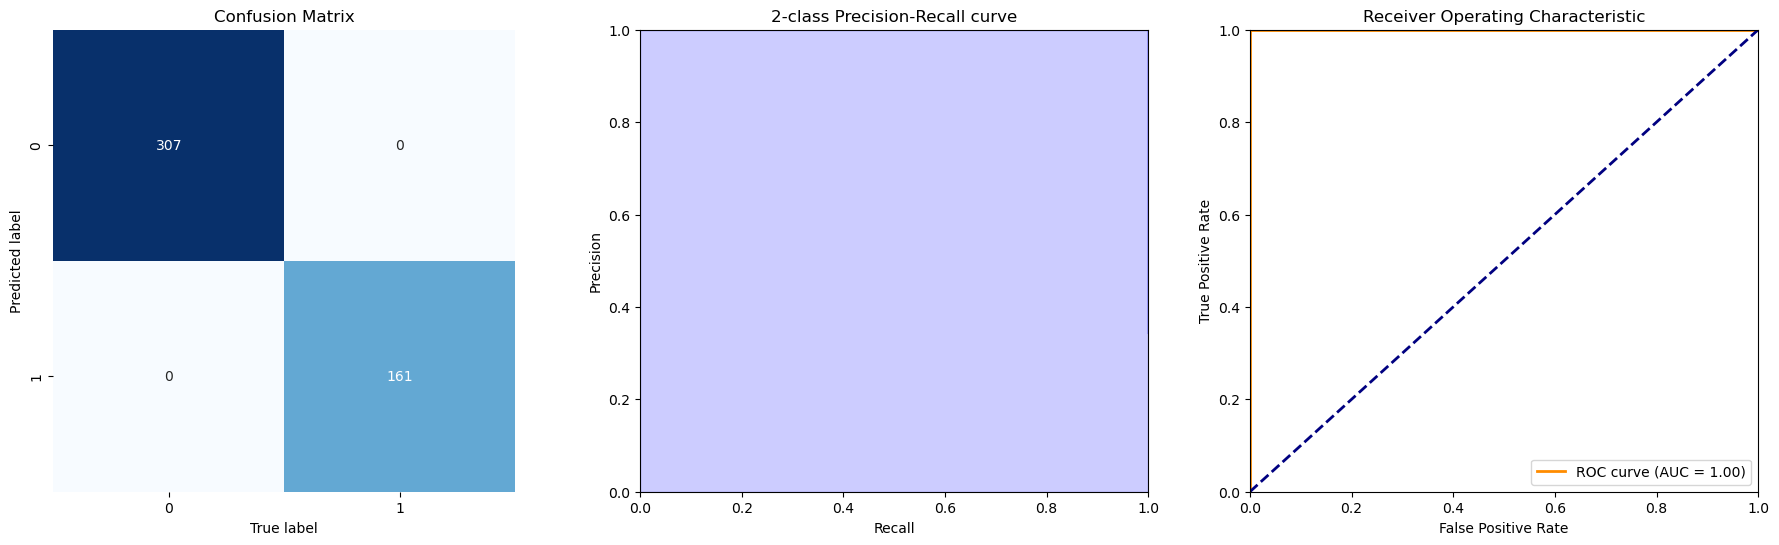


************
* Boosting *
************
Accuracy : 0.9915 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9876 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9876 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9999                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


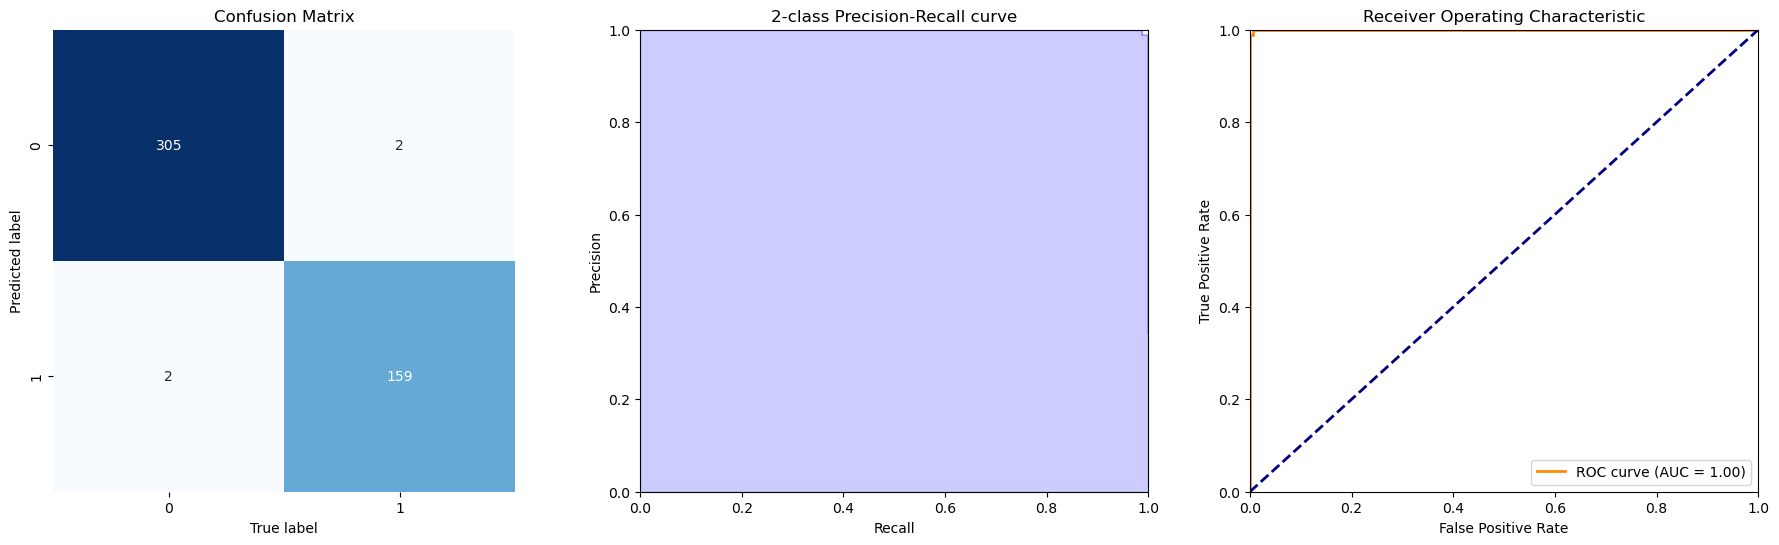

In [13]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['Decision Tree', 'Boosting']
for i, m in enumerate([cart, model]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    probabilities = m.predict_proba(X_train)[:,1]
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()


## _____________________________
## New Data Set

In [14]:
# Import models and utility functions
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
# Setting SEED for reproducibility
SEED = 23
# Importing the dataset
X, y = load_digits(return_X_y=True)
# Splitting dataset
train_X, test_X, train_y, test_y = train_test_split(X, y,
													test_size = 0.25,
													random_state = SEED)
# Instantiate Gradient Boosting Regressor
gbc = GradientBoostingClassifier(n_estimators=300,
								learning_rate=0.05,
								random_state=100,
								max_features=5 )
# Fit to training set
gbc.fit(train_X, train_y)
# Predict on test set
pred_y = gbc.predict(test_X)
# accuracy
acc = accuracy_score(test_y, pred_y)
print("Gradient Boosting Classifier accuracy is : {:.2f}".format(acc))

Gradient Boosting Classifier accuracy is : 0.98


In [15]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

### Stacking

In [16]:
## reading and inspect the data
columns = [
    'Sample_Number',
    'Clump_Thickness',
    'Uniformity_of_Cell_Size',
    'Uniformity_of_Cell_Shape',
    'Marginal_Adhesion',
    'Single_Epithelial_Cell_Size',
    'Bare_Nuclei',
    'Bland_Chromatin',
    'Normal_Nucleoli',
    'Mitoses',
    'Class'
]
df = pd.read_csv(
    filepath_or_buffer = '/Users/patrickjones/Desktop/VCU Data Science and AI/DATA/breast-cancer-wisconsin-data-old.csv',
    header = 0,
    names = columns,
    usecols = columns[1:], # do not use the first column
    na_values = '?' # convert the '?' to NA
)

In [17]:
print(df['Bare_Nuclei'].value_counts(dropna = False))

Bare_Nuclei
1.0     402
10.0    132
2.0      30
5.0      30
3.0      28
8.0      21
4.0      19
NaN      16
9.0       9
7.0       8
6.0       4
Name: count, dtype: int64


In [18]:
# Convert the DataFrame object into NumPy array otherwise you will not be able to impute
values = df.values
# define the criteria for dealing with the missing values
imputer = SimpleImputer(
    missing_values = np.nan,
    strategy = 'median'
)
# Now impute it
imputedData = imputer.fit_transform(values)

In [19]:
# Now that it's normalized we need to scale the data
scaler = MinMaxScaler(feature_range = (0, 1))
normalizedData = scaler.fit_transform(imputedData)

In [20]:
# move the data back to a dataframe
df_n = pd.DataFrame.from_records(normalizedData, columns = columns[1:])
df_n['Class'] = df_n['Class'].astype(np.int8)
df_n.sample(5)

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
521,0.333333,0.000000,0.000000,0.000000,0.222222,0.0,0.000000,0.000000,0.0,0
329,1.000000,0.333333,0.555556,0.333333,0.444444,1.0,0.666667,0.000000,0.0,1
378,0.222222,0.000000,0.000000,0.333333,0.222222,0.0,0.111111,0.111111,0.0,0
265,0.444444,0.000000,0.333333,0.000000,0.111111,0.0,0.222222,0.111111,0.0,0
255,0.444444,0.555556,0.555556,0.111111,0.333333,1.0,0.222222,0.555556,0.0,1


In [21]:
# create X and y to match Scikit-Learn parlance
features = columns[1:-1] # discard the first and last columns
outcome = 'Class'
# X include all the features
X = df_n[features].copy()
# y is the target variable
y = df_n[outcome].copy()

In [22]:
X.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,0.444444,0.000000,0.000000,0.000000,0.111111,0.000000,0.222222,0.000000,0.0
1,0.444444,0.333333,0.333333,0.444444,0.666667,1.000000,0.222222,0.111111,0.0
2,0.222222,0.000000,0.000000,0.000000,0.111111,0.111111,0.222222,0.000000,0.0
3,0.555556,0.777778,0.777778,0.000000,0.222222,0.333333,0.222222,0.666667,0.0
4,0.333333,0.000000,0.000000,0.222222,0.111111,0.000000,0.222222,0.000000,0.0


In [23]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 7, stratify = y)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
np.random.seed(0)
# create the sub models
clf1 = KNeighborsClassifier(n_neighbors = 1)
clf1.fit(X_train, y_train)
clf2 = RandomForestClassifier(n_estimators = 10, random_state = 1)
clf2.fit(X_train, y_train)
clf3 = GaussianNB()
clf3.fit(X_train, y_train)
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
lr.fit(X_train, y_train)

LogisticRegression()

In [31]:
from sklearn.ensemble import StackingClassifier
# create the ensemble model
sclf = StackingClassifier(
    estimators = [('clf1', clf1), ('clf2', clf2), ('clf3', clf3)],
    final_estimator = lr)
sclf.fit(X_train, y_train)



StackingClassifier(estimators=[('clf1', KNeighborsClassifier(n_neighbors=1)),
                               ('clf2',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=1)),
                               ('clf3', GaussianNB())],
                   final_estimator=LogisticRegression())

************************
* KNeighborsClassifier *
************************
Accuracy : 1.0000 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 1.0000 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 1.0000                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


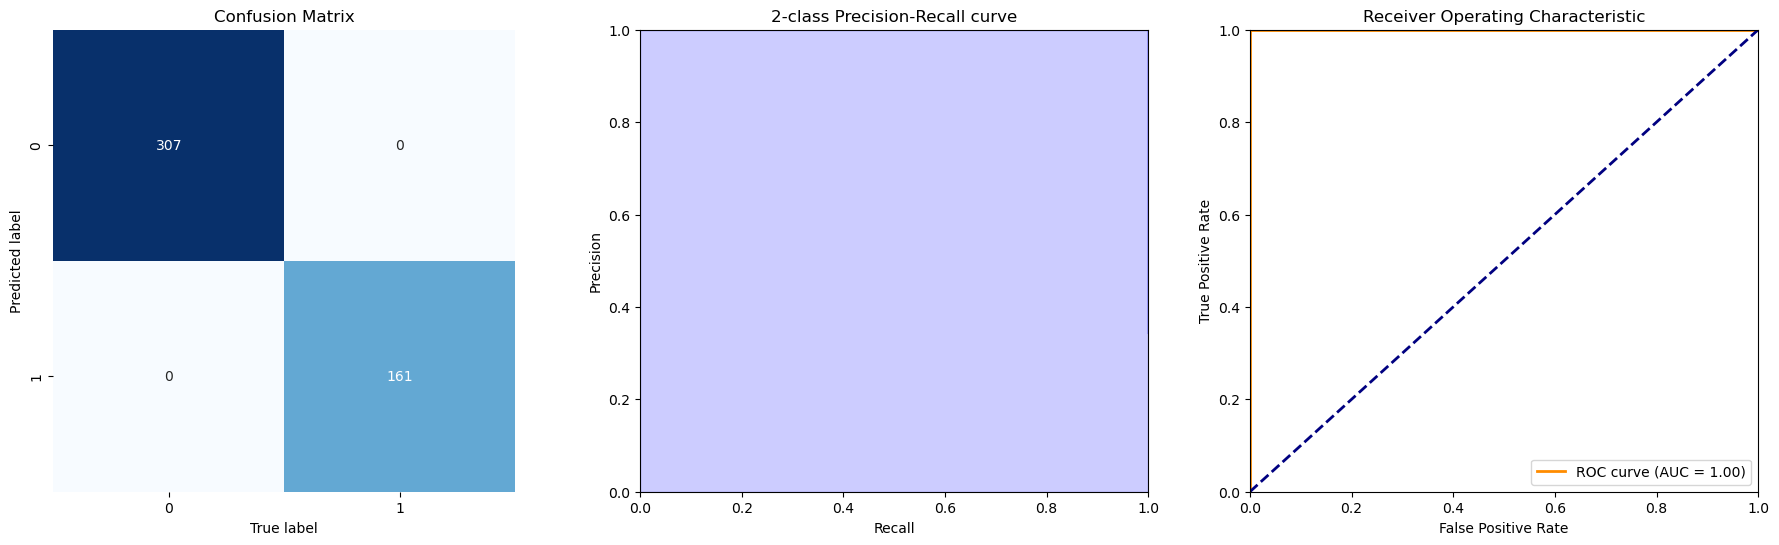


**************************
* RandomForestClassifier *
**************************
Accuracy : 0.9957 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9938 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9938 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9999                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


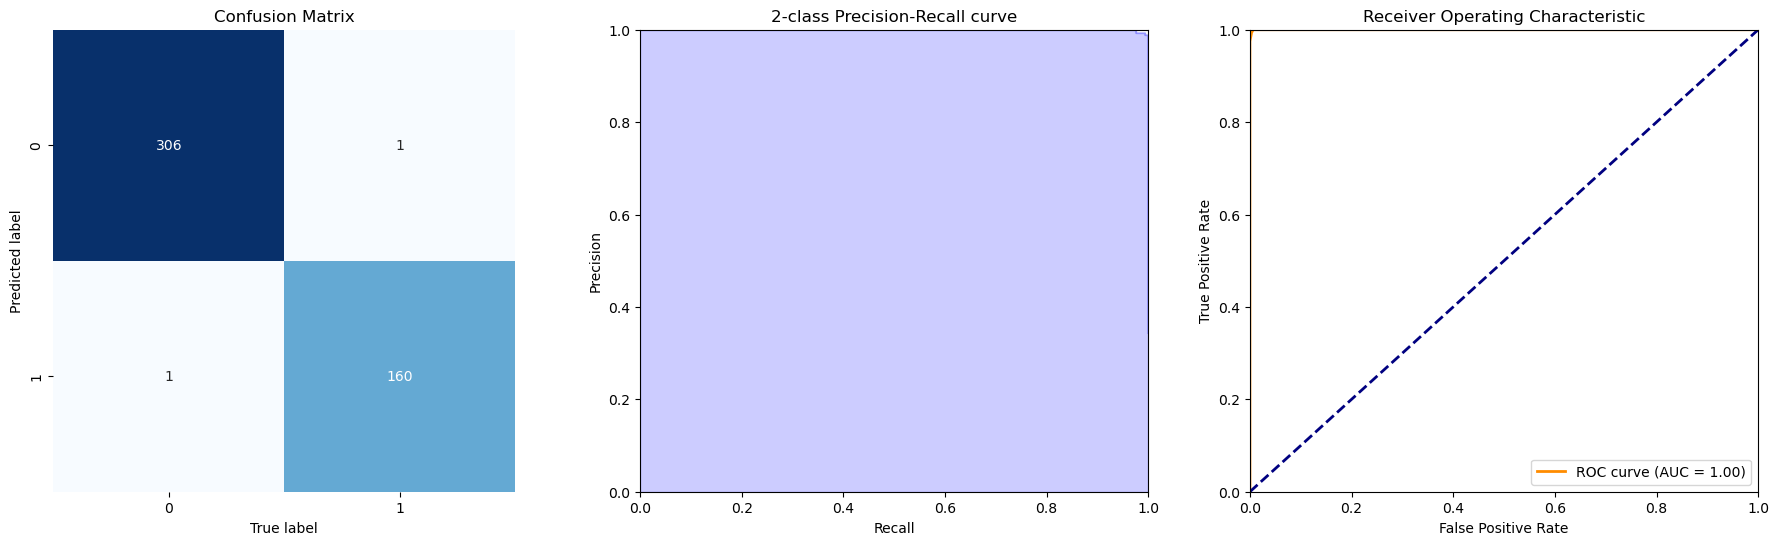


**************
* GaussianNB *
**************
Accuracy : 0.9530 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9017 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9689 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9841                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


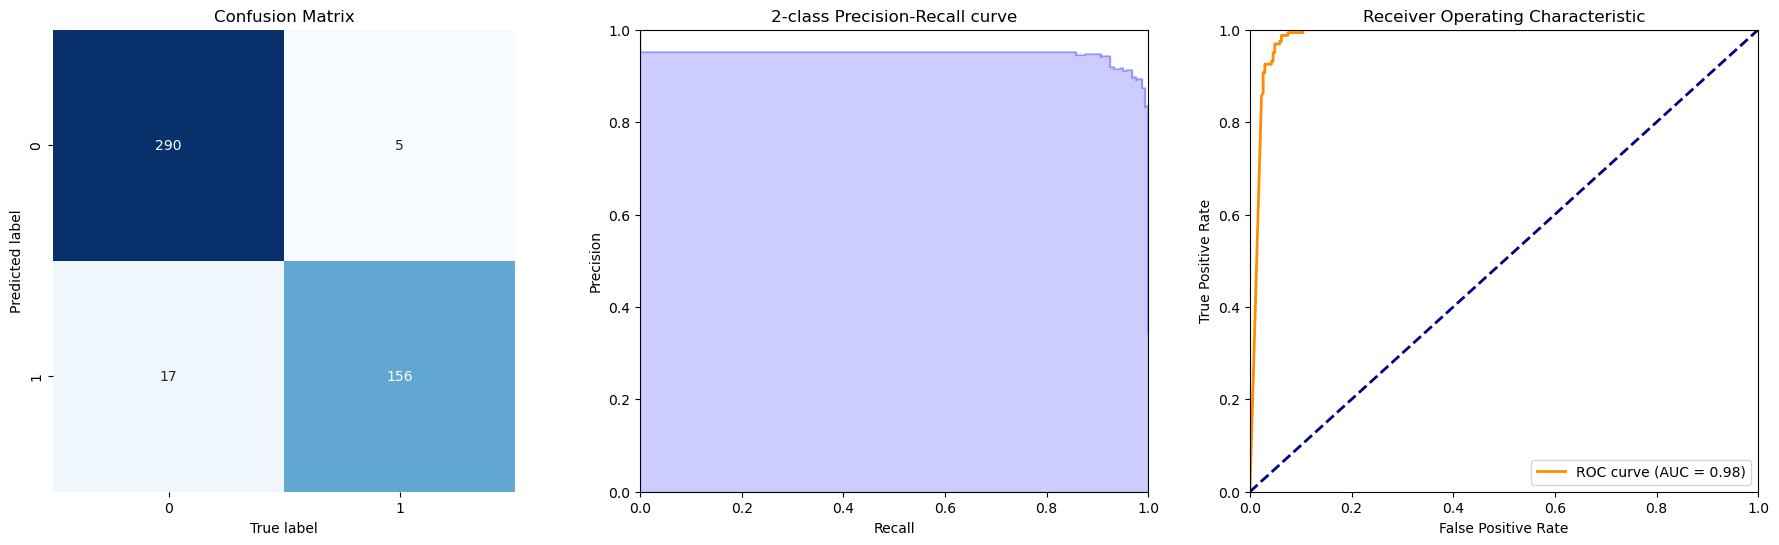


**********************
* LogisticRegression *
**********************
Accuracy : 0.9594 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9437 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9379 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9951                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


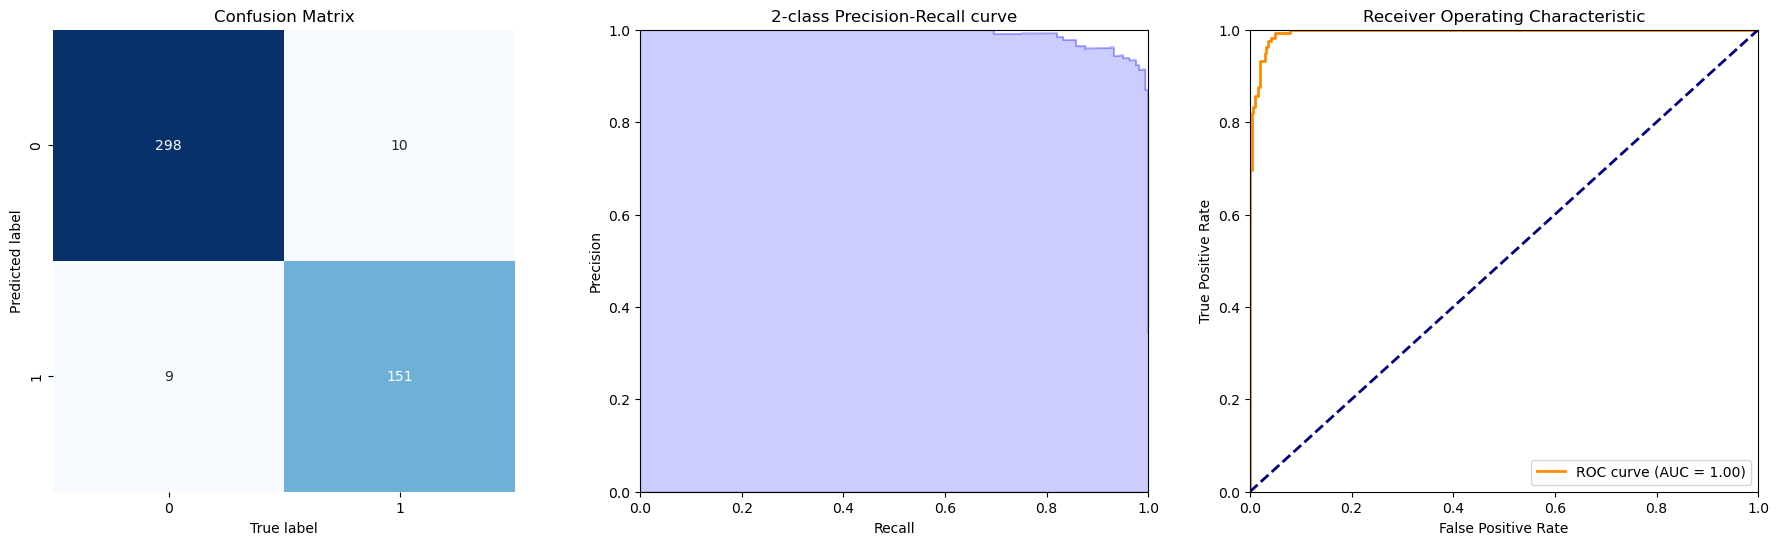


**********************
* StackingClassifier *
**********************
Accuracy : 0.9893 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9937 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9752 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9997                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


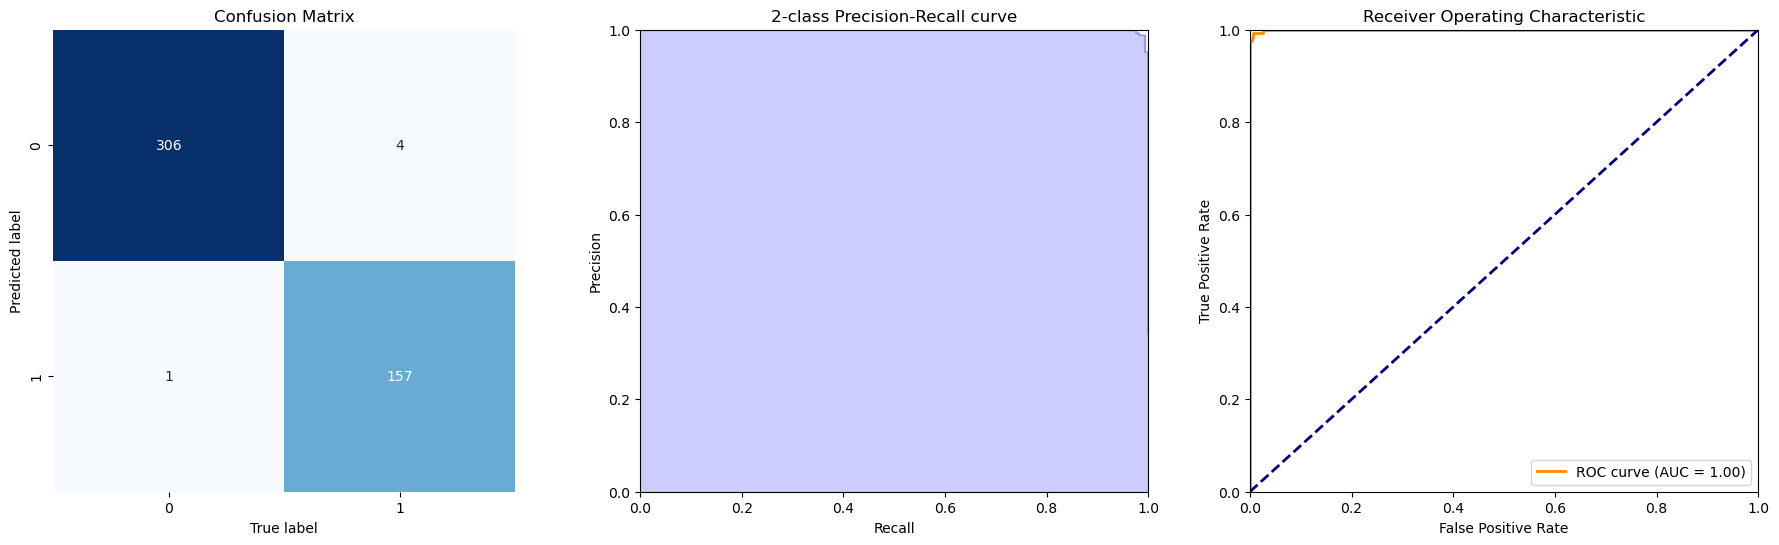

In [34]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])
models = ['KNeighborsClassifier', 'RandomForestClassifier', 'GaussianNB', 'LogisticRegression', 'StackingClassifier']
for i, m in enumerate([clf1, clf2, clf3, lr, sclf]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    probabilities = m.predict_proba(X_train)[:,1]
    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_train, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}
    print()